In [ ]:
pip uninstall qiskit qiskit-aer  -y

Found existing installation: qiskit 0.46.0
Uninstalling qiskit-0.46.0:
  Successfully uninstalled qiskit-0.46.0
Found existing installation: qiskit-aer 0.14.1
Uninstalling qiskit-aer-0.14.1:
  Successfully uninstalled qiskit-aer-0.14.1


In [ ]:
!pip install qiskit==0.46.0

  Using cached qiskit-0.46.0-py3-none-any.whl.metadata (12 kB)
Using cached qiskit-0.46.0-py3-none-any.whl (9.6 kB)


In [ ]:
!pip install qiskit-aer==0.14.1

  Using cached qiskit_aer-0.14.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.0 kB)
Using cached qiskit_aer-0.14.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Error Models

### Depolarizing error

In [ ]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error

# Create a simple quantum circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.measure_all()

# Define depolarizing error
# Single qubit depolarizing error with a probability of 0.1
dep_error = depolarizing_error(0.1, 1)

# Two-qubit depolarizing error with a probability of 0.2
dep_error_2q = depolarizing_error(0.2, 2)

# apply noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(dep_error,['u1', 'u2', 'u3', 'id'])
noise_model.add_all_qubit_quantum_error(dep_error_2q,['cx'])

# Simulate the circuit with the noise model
simulator = AerSimulator()
result = simulator.run(qc, noise_model=noise_model, shots=1024).result()

# Get and display results
counts = result.get_counts(qc)
print("Counts wih depolarizing error:", counts)

Counts wih depolarizing error: {'01': 57, '11': 466, '00': 446, '10': 55}


### Measurement Error
#### Although we did not use it later in circuit, we use direct ibm computer

In [ ]:
from qiskit.providers.aer.noise import ReadoutError

# Define a measurement error matrix
# This matrix shows the probability of measuring 0 or 1 when the actual state is 0 or 1
error_matrix = [[0.9, 0.1], [0.2, 0.8]]
readout_error = ReadoutError(error_matrix)

# Add readout error to the noise model
noise_model.add_all_qubit_readout_error(readout_error)

# Simulate with readout error
result_with_meas_error = simulator.run(qc, noise_model=noise_model, shots=1024).result()

# Get and display results
counts_with_meas_error = result_with_meas_error.get_counts(qc)
print("Counts wih measurement error:", counts_with_meas_error)

Counts wih measurement error: {'01': 162, '11': 308, '10': 139, '00': 415}


## Training Data Generation

In [ ]:
! pip install torchquantum qiskit-ibm-runtime

In [ ]:
import torchquantum as tq
import torchquantum.functional as tqf
from qiskit import QuantumCircuit, Aer, execute
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error
from qiskit.visualization import plot_histogram
import numpy as np
import random
import pandas as pd
import pickle

# Generate random quantum circuits
def generate_random_circuit(num_qubits, depth):
    qc = QuantumCircuit(num_qubits)
    for _ in range(depth):
        # Apply random single qubit gates
        for q in range(num_qubits):
            gate_choice = random.choice([qc.h, qc.x, qc.y, qc.z, qc.s, qc.t])
            gate_choice(q)
        # apply random two-qubit gate
        if num_qubits > 1:
            q1, q2 = random.sample(range(num_qubits), 2)
            qc.cx(q1,q2)
    qc.measure_all()
    return qc

# Simulate the ideal circuit (noiseless)
def simulate_ideal(circuit):
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuit, simulator, shots=1024).result()
    counts = result.get_counts(circuit)
    return counts

# Simulate the noisy circuit (with depolarizing noise)
def simulate_noisy(circuit, noise_model):
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuit, simulator, noise_model=noise_model, shots=1024).result()
    counts = result.get_counts(circuit)
    return counts

# Calculate the error between the ideal and noisy results
def calculate_error(ideal_counts, noisy_counts, num_qubits):
    ideal_prob = np.array([ideal_counts.get(format(i, f'0{num_qubits}b'),0) / 1024 for i in range(2**num_qubits)])
    noisy_prob = np.array([noisy_counts.get(format(i, f'0{num_qubits}b'),0) / 1024 for i in range(2**num_qubits)])
    error = noisy_prob - ideal_prob
    return error

# Generate training data
def generate_training_data(num_samples, num_qubits, depth, noise_model):
    data = []
    for _ in range(num_samples):
        qc = generate_random_circuit(num_qubits, depth)
        ideal_counts = simulate_ideal(qc)
        noisy_counts = simulate_noisy(qc, noise_model)
        error = calculate_error(ideal_counts, noisy_counts, num_qubits)
        circuit_str = qc.qasm() # store circuit as QASM string
        data.append({'circuit':circuit_str, 'error': error})
    return data

# Define a noise model (depolarizing error)
def create_noise_model():
    noise_model = NoiseModel()
    # define depolarizing error for single qubit gates
    dep_error = depolarizing_error(0.1,1)
    # apply the error to all single qubit gates
    noise_model.add_all_qubit_quantum_error(dep_error, ['u1', 'u2', 'u3', 'id'])
    return noise_model

# Store data in a dataframe
def save_data_to_dataframe(data):
    # Convert to dataframe
    df = pd.DataFrame(data)
    return df

# Save dataframe to CSV
def save_dataframe_to_csv(df, filename):
    df.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

# save data to a pickle file
def save_data_to_pickle(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Data saved to {filename}")

# Example usage
num_samples = 1000
num_qubits = 5
depth = 10

# Create noise model and generate data
noise_model = create_noise_model()
training_data = generate_training_data(num_samples, num_qubits, depth, noise_model)

# convert the data to a pandas Dataframe
df = save_data_to_dataframe(training_data)

# Save the dataframe to a CSV file
save_dataframe_to_csv(df, 'training_data.csv')

# (Optional) Save the data to a pickel file
save_data_to_pickle(training_data, 'training_data.pkl')

Data saved to training_data.csv
Data saved to training_data.pkl


# Ermse of depolarizing error

Processing for 2 qubits
Iteration 1/20
Iteration 2/20
Iteration 3/20
Iteration 4/20
Iteration 5/20
Iteration 6/20
Iteration 7/20
Iteration 8/20
Iteration 9/20
Iteration 10/20
Iteration 11/20
Iteration 12/20
Iteration 13/20
Iteration 14/20
Iteration 15/20
Iteration 16/20
Iteration 17/20
Iteration 18/20
Iteration 19/20
Iteration 20/20
Processing for 3 qubits
Iteration 1/20
Iteration 2/20
Iteration 3/20
Iteration 4/20
Iteration 5/20
Iteration 6/20
Iteration 7/20
Iteration 8/20
Iteration 9/20
Iteration 10/20
Iteration 11/20
Iteration 12/20
Iteration 13/20
Iteration 14/20
Iteration 15/20
Iteration 16/20
Iteration 17/20
Iteration 18/20
Iteration 19/20
Iteration 20/20
Processing for 5 qubits
Iteration 1/20
Iteration 2/20
Iteration 3/20
Iteration 4/20
Iteration 5/20
Iteration 6/20
Iteration 7/20
Iteration 8/20
Iteration 9/20
Iteration 10/20
Iteration 11/20
Iteration 12/20
Iteration 13/20
Iteration 14/20
Iteration 15/20
Iteration 16/20
Iteration 17/20
Iteration 18/20
Iteration 19/20
Iteration 2

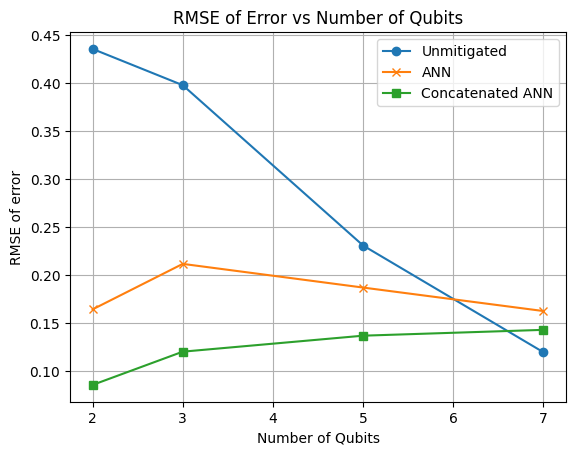

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchquantum as tq
from qiskit import QuantumCircuit, Aer, execute
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# define constants for the workflow
K = 3 # number of operations
imax = 20 # max number of iterations (training samples)
depth = 15 # depth of quantum circuits
shots = 1024 # number of shots for measurement

# Create the noise model (depolarizing error)
def create_noise_model():
    noise_model = NoiseModel()
    dep_error = depolarizing_error(0.1,1)
    noise_model.add_all_qubit_quantum_error(dep_error, ['u1', 'u2', 'u3', 'id'])
    return noise_model

noise_model = create_noise_model()

# Generate random quantum circuits
def generate_random_circuit(num_qubits, depth):
    qc = QuantumCircuit(num_qubits)
    for _ in range(depth):
        # Apply random single qubit gates
        for q in range(num_qubits):
            gate_choice = random.choice([qc.h, qc.x, qc.y, qc.z, qc.s, qc.t])
            gate_choice(q)
        # apply random two-qubit gate
        if num_qubits > 1:
            q1, q2 = random.sample(range(num_qubits), 2)
            qc.cx(q1,q2)
    qc.measure_all()
    return qc


# Simulate the ideal circuit (noiseless)
def simulate_ideal(circuit):
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuit, simulator, shots=shots).result()
    counts = result.get_counts(circuit)
    return counts

# Simulate the noisy circuit (with depolarizing noise)
def simulate_noisy(circuit, noise_model):
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuit, simulator, noise_model=noise_model, shots=shots).result()
    counts = result.get_counts(circuit)
    return counts

# Compute error (difference between ideal and noisy probabilities)
def calculate_error(ideal_counts, noisy_counts, num_qubits):
    ideal_prob = np.array([ideal_counts.get(format(i, f'0{num_qubits}b'),0) / shots for i in range(2**num_qubits)])
    noisy_prob = np.array([noisy_counts.get(format(i, f'0{num_qubits}b'),0) / shots for i in range(2**num_qubits)])
    error = noisy_prob - ideal_prob
    return error

# RMSE calculation
def calculate_rmse(ideal_counts, noisy_counts, num_qubits):
    ideal_prob = np.array([ideal_counts.get(format(i, f'0{num_qubits}b'),0) / shots for i in range(2**num_qubits)])
    noisy_prob = np.array([noisy_counts.get(format(i, f'0{num_qubits}b'),0) / shots for i in range(2**num_qubits)])
    return np.sqrt(mean_squared_error(ideal_prob, noisy_prob))

# define the ordinary ANN architecture
class OrdinaryANN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(OrdinaryANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the Concatenated ANN architecture
class ConcatenatedANN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ConcatenatedANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Instantiate both architecture
hidden_size = 16 # hidden layer size

#Arrays to store RMSE values for different qubit numbers
rmse_unmitigated = []
rmse_ordinary_ann = []
rmse_concatenated_ann = []

# qubit numbers to test
qubit_range = [2, 3,5,7]

for num_qubits in qubit_range:
    print(f"Processing for {num_qubits} qubits")

    # initialize ANN for this number of qubits
    # Corrected input_size calculation
    input_size =  2**num_qubits + K * 2 # Input size is the length of additional_inputs + error
    output_size = 2**num_qubits # Output size corresponds to the correction matrix

    ordinary_ann = OrdinaryANN(input_size, hidden_size, output_size)
    concatenated_ann = ConcatenatedANN(input_size, hidden_size, output_size)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer_ordinary = optim.Adam(ordinary_ann.parameters(), lr=0.001)
    optimizer_concatenated = optim.Adam(concatenated_ann.parameters(), lr=0.001)

    unmitigated_rmse_total = 0
    ordinary_ann_rmse_total = 0
    concatenated_ann_rmse_total = 0

    for i in range(imax):
        print(f"Iteration {i+1}/{imax}")

        batch_inputs = []
        batch_errors = []
        batch_size = 32 # Define a batch size

        for _ in range(batch_size):
            # generate a random quantum circuit
            qc = generate_random_circuit(num_qubits, depth)

            # Simulate the ideal and noisy versions of the circuit
            ideal_counts = simulate_ideal(qc)
            noisy_counts = simulate_noisy(qc,noise_model)

            # unmitigated rmse
            unmitigated_rmse_total += calculate_rmse(ideal_counts, noisy_counts, num_qubits)

            # calculate error between ideal and noisy outputs
            error = calculate_error(ideal_counts, noisy_counts, num_qubits)

            # additional input data
            G1 = random.randint(1,5)
            G2 = random.randint(1,3)
            additional_inputs = np.array([G1,G2] * K)

            # prepare input tensor
            input_tensor = np.concatenate((additional_inputs, error))

            batch_inputs.append(input_tensor)
            batch_errors.append(error)

        # Convert batches to tensors
        batch_inputs_tensor = torch.tensor(batch_inputs, dtype=torch.float32)
        batch_errors_tensor = torch.tensor(batch_errors, dtype=torch.float32)

        # training step for the Ordinary ANN
        optimizer_ordinary.zero_grad()
        output_ordinary = ordinary_ann(batch_inputs_tensor)
        loss_ordinary = criterion(output_ordinary, batch_errors_tensor)
        loss_ordinary.backward()
        optimizer_ordinary.step()

        # Training step for concatenated ANN
        optimizer_concatenated.zero_grad()
        output_concatenated = concatenated_ann(batch_inputs_tensor)
        loss_concatenated = criterion(output_concatenated, batch_errors_tensor)
        loss_concatenated.backward()
        optimizer_concatenated.step()

        # calculate RMSE for Ordinary ANN and concatenated Ann
        ordinary_ann_rmse_total += np.sqrt(mean_squared_error(output_ordinary.detach().numpy(),batch_errors_tensor.detach().numpy()))
        concatenated_ann_rmse_total += np.sqrt(mean_squared_error(output_concatenated.detach().numpy(),batch_errors_tensor.detach().numpy()))

    # Calculate average RMSE for this qubit size
    rmse_unmitigated.append(unmitigated_rmse_total/imax)
    rmse_ordinary_ann.append(ordinary_ann_rmse_total/imax)
    rmse_concatenated_ann.append(concatenated_ann_rmse_total/imax)

# Plotting RMSE for different qubit sizes
plt.plot(qubit_range, rmse_unmitigated, label='Unmitigated', marker ='o')
plt.plot(qubit_range, rmse_ordinary_ann, label='ANN', marker ='x')
plt.plot(qubit_range,  rmse_concatenated_ann, label='Concatenated ANN', marker = 's')

plt.title('RMSE of Error vs Number of Qubits')
plt.xlabel('Number of Qubits')
plt.ylabel('RMSE of error')
plt.legend()
plt.grid(True)
plt.show()